<a href="https://colab.research.google.com/github/yeowoobi/Aiffiel_Exploration/blob/master/CV_02_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going Deeper CV_02
---
### 없다면 어떻게 될까?

## 회고

이번 첫 Going Deeper 노드를 진행하면서 Exploration 노드와는 격차가 굉장히 있는게 느껴졌다.<br>결국 이번 노드의 코드작성을 결과적으로 하지 못하면서, 아래의 코드는 내가 작성한 것이 아니기에 먼저 회고를 작성하였다.<br><br>
지난 첫 데이터톤을 진행하면서 어느정도 코드를 찾아 쌓아가는 것에 재미도 있었고 약간의 자신감도 있었는데 이번 프로젝트를 진행하면서 큰 어려움을 느꼈다.<br>
기존의 VGG 블럭을  만드는 코드를 변형해서 만들려고 했지만 어느정도 진행이 되다가도 금방 다시 막히는 일이 빈번했다.<br> 결론적으로 코드를 이용하여 모델을 생성하지 못해서 다른 사람들이 진행했던 코드들을 살펴보았고 아래의 코드는 @JaeHee 님의 Github의 코드를 그대로 가져온 것이다. <br><br>

이번 프로젝트를 하면서 단순히 알고리즘, 파이썬 코딩에 대해서 공부를 하는 것도 중요하지만 kaggle, 혹은 지난 Exploration Node 들을 복습하는 것이 중요한 것을 느꼈다.<br> 
_(이 코드들을 __필사__하면서 주요 라이브러리, 메소드 들에 대한 사용법을 익혀 보려 한다.)_ <br>
또한 논문을 읽는 것에 대한 필요성도 실감을 하면서 논문의 내용을 코드로 구현 하는 것에 대한 과정도 많은 노력과 연구가 필요할 것 같다.

## 0. 라이브러리 버전 확인하기 

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


## 1. ResNet 기존 블록 구성하기

### ConvBlock

In [ ]:
def conv_batch(layer, 
               channel, 
               kernel_size, 
               padding='same', 
               strides=1, 
               activation='relu', 
               name='0'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size = kernel_size,
                            kernel_initializer = 'he_normal',
                            kernel_regularizer = keras.regularizers.l2(1e-4),
                            padding = padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'activation_{name}')(x)
    
    return x

### Plain Network

In [4]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

In [5]:
def build_plain(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

In [6]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 activation_first (Activatio  (None, 112, 112, 64)     0         
 n)                                                              
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                          

In [7]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv_first (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_first (BatchNormaliza  (None, 112, 112, 64)     256       
 tion)                                                           
                                                                 
 activation_first (Activatio  (None, 112, 112, 64)     0         
 n)                                                              
                                                                 
 maxpool_first (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                          

### Residual Network

### 2) ResNet-34, ResNet-50 Complete *Model*

In [8]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

In [9]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

In [10]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

In [11]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_first (Conv2D)            (None, 112, 112, 64  9472        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_first (BatchNormalizatio  (None, 112, 112, 64  256        ['conv_first[0][0]']             
 n)                             )                                                         

## 2. Ablation Study

### Data Load (`cats_vs_dogs` 데이터)

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

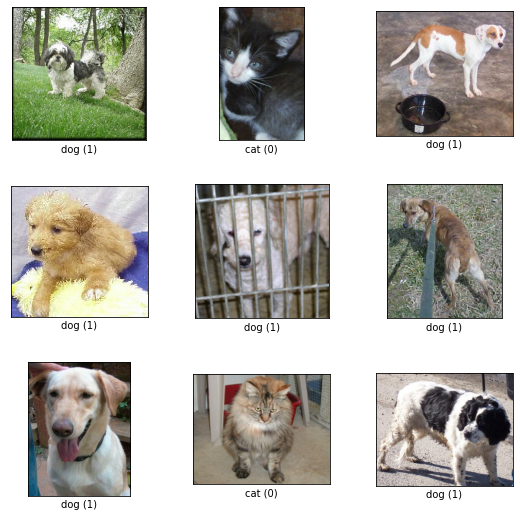

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

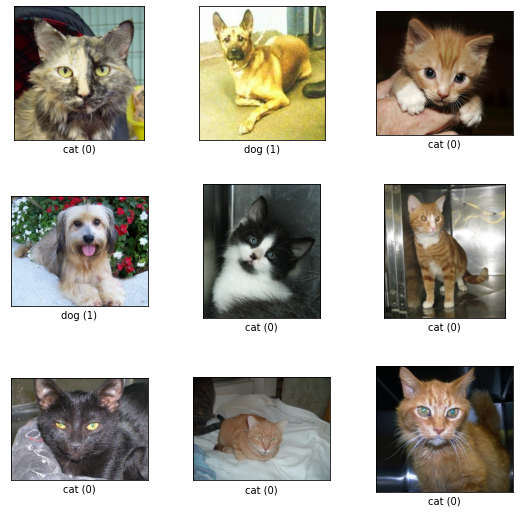

In [16]:
fig = tfds.show_examples(ds_test, ds_info)

### Plan-34 vs ResNet-34

In [17]:
BATCH_SIZE = 32
EPOCH = 15

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [19]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [20]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [ ]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 92s 117ms/step - loss: 2.1000 - accuracy: 0.5119 - val_loss: 1.9130 - val_accuracy: 0.5226 - lr: 0.1000
Epoch 2/15
654/654 [==============================] - 75s 115ms/step - loss: 1.7602 - accuracy: 0.5266 - val_loss: 1.6373 - val_accuracy: 0.5317 - lr: 0.1000
Epoch 3/15
654/654 [==============================] - 75s 115ms/step - loss: 1.5137 - accuracy: 0.5373 - val_loss: 1.4146 - val_accuracy: 0.5022 - lr: 0.1000
Epoch 4/15
654/654 [==============================] - 75s 115ms/step - loss: 1.3230 - accuracy: 0.5485 - val_loss: 1.2478 - val_accuracy: 0.5247 - lr: 0.1000
Epoch 5/15
654/654 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.5492
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================] - 75s 115ms/step - loss: 1.1771 - accuracy: 0.5492 - val_loss: 1.4094 - val_accuracy: 0.5894 - lr: 0.1000
Epoch 6/15
654/654 [==============================] - 76s 116

In [21]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [22]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 110s 124ms/step - loss: 2.3026 - accuracy: 0.5556 - val_loss: 2.8170 - val_accuracy: 0.5306 - lr: 0.1000
Epoch 2/15
654/654 [==============================] - 78s 119ms/step - loss: 1.8568 - accuracy: 0.6148 - val_loss: 1.6921 - val_accuracy: 0.6246 - lr: 0.1000
Epoch 3/15
654/654 [==============================] - 78s 119ms/step - loss: 1.5546 - accuracy: 0.6570 - val_loss: 1.4369 - val_accuracy: 0.6607 - lr: 0.1000
Epoch 4/15
654/654 [==============================] - ETA: 0s - loss: 1.3231 - accuracy: 0.6868
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================] - 78s 120ms/step - loss: 1.3231 - accuracy: 0.6868 - val_loss: 2.4288 - val_accuracy: 0.5156 - lr: 0.1000
Epoch 5/15
654/654 [==============================] - 78s 120ms/step - loss: 1.1642 - accuracy: 0.7341 - val_loss: 1.1385 - val_accuracy: 0.7474 - lr: 0.0100
Epoch 6/15
654/654 [==============================] - ETA: 0

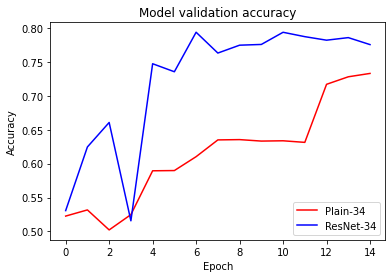

In [30]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-34', 'ResNet-34', ], loc='lower right')
plt.show()

### Plan-50 vs ResNet-50

In [26]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [27]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 127s 164ms/step - loss: 4.8086 - accuracy: 0.5042 - val_loss: 4.2581 - val_accuracy: 0.5166 - lr: 0.1000
Epoch 2/15
654/654 [==============================] - 106s 162ms/step - loss: 3.8258 - accuracy: 0.5377 - val_loss: 3.4398 - val_accuracy: 0.5104 - lr: 0.1000
Epoch 3/15
654/654 [==============================] - 106s 162ms/step - loss: 3.0996 - accuracy: 0.5609 - val_loss: 2.8006 - val_accuracy: 0.4957 - lr: 0.1000
Epoch 4/15
654/654 [==============================] - 106s 162ms/step - loss: 2.5420 - accuracy: 0.5671 - val_loss: 2.3171 - val_accuracy: 0.5569 - lr: 0.1000
Epoch 5/15
654/654 [==============================] - 106s 162ms/step - loss: 2.1305 - accuracy: 0.5224 - val_loss: 1.9616 - val_accuracy: 0.5109 - lr: 0.1000
Epoch 6/15
654/654 [==============================] - 106s 163ms/step - loss: 1.8064 - accuracy: 0.5334 - val_loss: 1.6839 - val_accuracy: 0.4904 - lr: 0.1000
Epoch 7/15
654/654 [==============================] - 107

In [28]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [29]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


654/654 [==============================] - 88s 103ms/step - loss: 5.6292 - accuracy: 0.5556 - val_loss: 4.8912 - val_accuracy: 0.5315 - lr: 0.1000
Epoch 2/15
654/654 [==============================] - 66s 100ms/step - loss: 4.3348 - accuracy: 0.6424 - val_loss: 3.9090 - val_accuracy: 0.5786 - lr: 0.1000
Epoch 3/15
654/654 [==============================] - 66s 100ms/step - loss: 3.4748 - accuracy: 0.6747 - val_loss: 3.2395 - val_accuracy: 0.5508 - lr: 0.1000
Epoch 4/15
654/654 [==============================] - 66s 101ms/step - loss: 2.7852 - accuracy: 0.7170 - val_loss: 2.7583 - val_accuracy: 0.5744 - lr: 0.1000
Epoch 5/15
654/654 [==============================] - 66s 101ms/step - loss: 2.2396 - accuracy: 0.7579 - val_loss: 2.0439 - val_accuracy: 0.7474 - lr: 0.1000
Epoch 6/15
654/654 [==============================] - 66s 102ms/step - loss: 1.8314 - accuracy: 0.7780 - val_loss: 1.7098 - val_accuracy: 0.7609 - lr: 0.1000
Epoch 7/15
654/654 [==============================] - ETA: 0s -

In [22]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

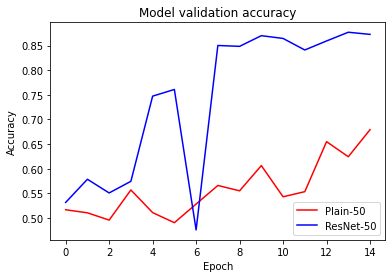

In [31]:
plt.plot(history_plain_50.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain-50', 'ResNet-50', ], loc='lower right')
plt.show()

## 3. 후기

### 1.모델에 대한 평가

내가 직접 작성한 코드가 아니기 때문에 모델에 대한 평가를 하는 것 자체가 불가하지만 결과 차트만 보았을 때, ResNet-34, ResNet-50 모두 Plane Network 에 비하여 정확도가 높은 것을 확인할 수 있었다.


### 2. Reference

[1] https://jxnjxn.tistory.com/22<br>
[2] https://velog.io/@qsdcfd/ResNet-%EB%85%BC%EB%AC%B8 <br>
[3] https://github.com/PEBpung/Aiffel/blob/master/Project/Going%20Deeper/G2.%20ResNet%20Ablation%20Study.ipynb<br>
[4] https://github.com/JaeHeee/AIFFEL_Project/blob/master/Going_Deeper/ResNet.ipynb<br>
[5] https://github.com/ljh415/AIFFEL/blob/master/Going_Deeper/01.ResNet_Ablation_Study/ResNet_Ablation_Study.ipynb